# Holo2Bright with CycleGAN

We'll build a CycleGAN model to convert Holographic microscopy images to Brightfield microscopy images and vice versa.

## The Holo2Bright dataset

Write description about the dataset here. And link it to the transforms in the end.

In [1]:
from torchvision import transforms

transform = [
    # transforms for holographic images
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),

    # transforms for brightfield images
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
]

In [16]:
from dataset import Holo2BrightDataset

root = '/Users/xbacss/Documents/GitHub/holo2bright_dataset'
train_dataset = Holo2BrightDataset(root, train=True, transform=transform)
test_dataset = Holo2BrightDataset(root, train=False, transform=transform)

We can now visualize some images from the training dataset using the `matplotlib` package.

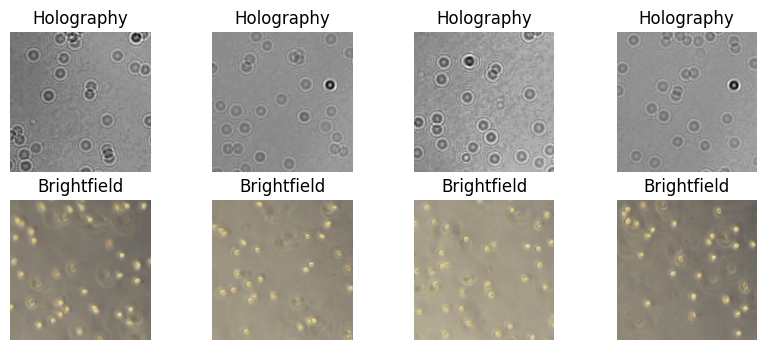

In [17]:
import torch
import matplotlib.pyplot as plt

def denormalize_image(image):
    image = image * 0.5 + 0.5
    return image

fig, ax = plt.subplots(2, 4, figsize=(10, 4))
for i in range(4):
    holography_image, brightfield_image = train_dataset[torch.randint(0, len(train_dataset), (1,)).squeeze()]

    # print('H', torch.max(holography_image), torch.min(holography_image))
    # print('B', torch.max(brightfield_image), torch.min(brightfield_image))

    ax[0, i].imshow(denormalize_image(holography_image.permute(1, 2, 0).squeeze()), cmap='gray')
    ax[0, i].axis('off')
    ax[0, i].set_title('Holography')

    ax[1, i].imshow(denormalize_image(brightfield_image.permute(1, 2, 0).squeeze()))
    ax[1, i].axis('off')
    ax[1, i].set_title('Brightfield')

plt.show()

Create device

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


CycleGAN Generator

In [20]:
import deeplay as dl

generator_H2B = dl.CycleGANGenerator(in_channels=1, out_channels=3).build()
generator_B2H = dl.CycleGANGenerator(in_channels=3, out_channels=1).build()

generator_H2B.to(device)
generator_B2H.to(device)
# print(generator_H2B)

CycleGANGenerator(
  (blocks): LayerList(
    (0): CycleGANBlock(
      (layer): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
      (normalization): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): ReLU()
    )
    (1): CycleGANBlock(
      (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
      (normalization): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): ReLU()
    )
    (2): CycleGANBlock(
      (layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
      (normalization): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): ReLU()
    )
    (3-11): 9 x ResidualBlock(
      (blocks): LayerList(
        (0): CycleGANBlock(
          (layer): Conv2d(256, 256, kernel_size=(3, 3), stride=(

CycleGAN Discriminator

In [21]:
discriminator_H = dl.CycleGANDiscriminator(in_channels=1).build()
discriminator_B = dl.CycleGANDiscriminator(in_channels=3).build()

discriminator_H.to(device)
discriminator_B.to(device)
# print(discriminator_H)

CycleGANDiscriminator(
  (blocks): LayerList(
    (0): PatchGANBlock(
      (layer): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
      (normalization): Identity()
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (1): PatchGANBlock(
      (layer): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
      (normalization): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (2): PatchGANBlock(
      (layer): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
      (normalization): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (3): PatchGANBlock(
      (layer): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (normalization):

Loss functions

In [11]:
Loss_Generator = torch.nn.MSELoss()
Loss_Discriminator = torch.nn.L1Loss()

Optimizers

In [22]:
optimizer_generator = torch.optim.Adam(
    list(generator_H2B.parameters()) + list(generator_B2H.parameters()),
    lr=0.0002,
    betas=(0.5, 0.999)
)

optimizer_discriminator = torch.optim.Adam(
    list(discriminator_H.parameters()) + list(discriminator_B.parameters()),
    lr=0.0002,
    betas=(0.5, 0.999)
)

Create data loaders

In [18]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False)

Let us define a function to train the CycleGAN model. We will use this function later in the training loop.

In [13]:
def train_model(
    input_image_H, input_image_B, optimizer_disc, optimizer_gen, L1_LambdaH, L1_LambdaB
):
    # zero the parameter gradients
    optimizer_disc.zero_grad()

    # 1. Training both the discriminators

    # Train discriminator B (As a part of the transformation Holography (H) -> Brightfield (B))
    fake_image_B = generator_H2B(input_image_H)
    disc_B_output_real = discriminator_B(input_image_B)
    disc_B_output_fake = discriminator_B(fake_image_B.detach())

    disc_B_loss_real = Loss_Discriminator(disc_B_output_real, torch.ones_like(disc_B_output_real))
    disc_B_loss_fake = Loss_Discriminator(disc_B_output_fake, torch.zeros_like(disc_B_output_fake))

    disc_B_loss = disc_B_loss_real + disc_B_loss_fake

    # Train discriminator H (As a part of the transformation Brightfield (B) -> Holography (H))
    fake_image_H = generator_B2H(input_image_B)
    disc_H_output_real = discriminator_H(input_image_H)
    disc_H_output_fake = discriminator_H(fake_image_H.detach())

    disc_H_loss_real = Loss_Discriminator(disc_H_output_real, torch.ones_like(disc_H_output_real))
    disc_H_loss_fake = Loss_Discriminator(disc_H_output_fake, torch.zeros_like(disc_H_output_fake))

    disc_H_loss = disc_H_loss_real + disc_H_loss_fake

    # Total discriminator loss
    disc_loss = (disc_B_loss + disc_H_loss) / 2

    # Backpropagate discriminator loss
    disc_loss.backward()

    # Update weights of discriminators
    optimizer_disc.step()

    # 2. Training both the generators for each discriminator training

    # Train generator H2B (As a part of the transformation Holography (H) -> Brightfield (B))
    disc_B_output_fake = discriminator_B(fake_image_B)
    disc_H_output_fake = discriminator_H(fake_image_H)

    # Adversarial loss (from generators perspective)
    gen_H2B_loss = Loss_Discriminator(disc_B_output_fake, torch.ones_like(disc_B_output_fake))
    gen_B2H_loss = Loss_Discriminator(disc_H_output_fake, torch.ones_like(disc_H_output_fake))

    # zero the parameter gradients
    optimizer_gen.zero_grad()

    # 3. Cycle consistency loss
    cycle_H = generator_B2H(fake_image_B) # Holography (H) -> Brightfield (B) -> Holography (H)
    cycle_B = generator_H2B(fake_image_H) # Brightfield (B) -> Holography (H) -> Brightfield (B)
    cycle_H_loss = Loss_Generator(input_image_H, cycle_H)
    cycle_B_loss = Loss_Generator(input_image_B, cycle_B)

    # Total generator loss
    gen_loss = (
        gen_H2B_loss
        + gen_B2H_loss
        + L1_LambdaH * cycle_H_loss
        + L1_LambdaB * cycle_B_loss
    )

    # Backpropagate generator loss
    gen_loss.backward()

    # Update weights of generators
    optimizer_gen.step()

    return disc_loss, gen_loss

Let us now define a function to evaluate model performance in between epochs. We will use this function later in the training loop.

In [ ]:
def evaluate_model(image_H, image_B):
    generator_H2B.eval()
    generator_B2H.eval()

    fake_image_B = generator_H2B(image_H)
    fake_image_H = generator_B2H(image_B)

    generator_H2B.train()
    generator_B2H.train()

    # plot the images
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    ax[0, 0].imshow(
        denormalize_image(image_H[0].permute(1, 2, 0).cpu().detach().numpy()), cmap="gray"
    )
    ax[0, 0].set_title("Input image holography")
    ax[0, 0].axis("off")

    ax[1, 0].imshow(
        denormalize_image(image_B[0].permute(1, 2, 0).cpu().detach().numpy())
    )
    ax[1, 0].set_title("Input image brightfield")
    ax[1, 0].axis("off")

    ax[0, 1].imshow(
        denormalize_image(fake_image_B[0].permute(1, 2, 0).cpu().detach().numpy())
    )
    ax[0, 1].set_title("Generated image brightfield")
    ax[0, 1].axis("off")

    ax[1, 1].imshow(
        denormalize_image(fake_image_H[0].permute(1, 2, 0).cpu().detach().numpy()), cmap="gray"
    )
    ax[1, 1].set_title("Generated image holography")
    ax[1, 1].axis("off")

    return fig

Training loop

In [ ]:
# Train the CycleGAN
epochs = 100
generator_loss = []
discriminator_loss = []

import numpy as np
for epoch in range(epochs):
    n_batches = len(train_loader)

    print("\n")

    print(f"Epoch {epoch+1}/{epochs}")
    print("-" * 10)

    # looping over batches
    G_loss_epochs = []
    D_loss_epochs = []

    for i, data in enumerate(train_loader, 0):
        # get the domain H and B images for each batch

        inputs_H, inputs_B = data
        inputs_H, inputs_B = inputs_H.to(device), inputs_B.to(device)

        # Train the model
        disc_loss, gen_loss = train_model(
            inputs_H, inputs_B, optimizer_generator, optimizer_discriminator, L1_LambdaA=10, L1_LambdaB=5
        )

        # Print the loss for this batch
        if i % 20 == 0:
            print(
                f"Batch {i+1}/{n_batches} : Generator Loss: {gen_loss.item():.4f}, Discriminator Loss: {disc_loss.item():.4f}"
            )

        # Save the loss for this batch
        G_loss_epochs.append(gen_loss.item())
        D_loss_epochs.append(disc_loss.item())

    if epoch % 1 == 0:
        for i, data in enumerate(test_loader, 0):
            # get the domain H and B images for each batch
            test_inputs_H, test_inputs_B = data
            test_inputs_H, test_inputs_B = test_inputs_H.to(device), test_inputs_B.to(
                device
            )
            break

        # Evaluate the model
        fig = evaluate_model(test_inputs_H, test_inputs_B)
        plt.show()

    # Save the loss for this epoch
    generator_loss.append(np.mean(G_loss_epochs))
    discriminator_loss.append(np.mean(D_loss_epochs))

    # Print the loss for this epoch
    print("-" * 10)
    print(
        f"Epoch {epoch+1}/{epochs} : Generator Loss: {np.mean(G_loss_epochs):.4f}, Discriminator Loss: {np.mean(D_loss_epochs):.4f}"
    )

    del inputs_H, inputs_B, disc_loss, gen_loss